In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import copy
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from time import time
import lightgbm as lgb
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [ ]:
train = pd.read_csv('/content/drive/My Drive/zimnat/Train.csv')
test = pd.read_csv('/content/drive/My Drive/zimnat/Test.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/zimnat/SampleSubmission.csv')

train.shape, test.shape, sample_submission.shape

((29132, 29), (10000, 29), (210000, 2))

In [ ]:
train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,1/8/2019,M,M,1990,1X1H,BP09,56SI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,1/8/2019,M,M,1990,748L,NO3L,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [ ]:
X_train = []
X_train_columns = train.columns

for v in tqdm_notebook(train.values):
    info = v[:8]
    binary = v[8:]

    index = [k for k, i in enumerate(binary) if i == 1]

    for i in index:
        for k in range(len(binary)):
            if k == i:
                binary_transformed = list(copy.copy(binary))
                binary_transformed[i] = 0
                X_train.append(list(info) + binary_transformed + [X_train_columns[8 + k]])

X_train = pd.DataFrame(X_train)       
X_train.columns = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3', 'product_pred']         

In [ ]:
X_test = []
true_values = []

for v in tqdm_notebook(test.values):
    info = v[:8]
    binary = v[8:]
    index = [k for k, i in enumerate(binary) if i == 1]

    X_test.append(list(info) + list(binary))
    for k in test.columns[8:][index]:
        true_values.append(v[0] + ' X ' + k)

X_test = pd.DataFrame(X_test)
X_test.columns = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']

In [ ]:
y_train = X_train['product_pred']

X_train = X_train[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 
'N2MW', 'AHXO','BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 
'ECY3', 'ID', 'join_date', 'sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code',
'birth_year']]

X_test = X_test[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 
'N2MW', 'AHXO','BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 
'ECY3', 'ID', 'join_date', 'sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code',
'birth_year']]

In [ ]:
X_train['date1'] = X_train['join_date'].apply(lambda x: int(x.split('/')[0]) if (x == x) else np.nan)
X_train['date2'] = X_train['join_date'].apply(lambda x: int(x.split('/')[1]) if (x == x) else np.nan)
X_train['date3'] = X_train['join_date'].apply(lambda x: int(x.split('/')[2]) if (x == x) else np.nan)
X_train.drop('join_date', axis=1, inplace=True)

X_test['date1'] = X_test['join_date'].apply(lambda x: int(x.split('/')[0]) if (x == x) else np.nan)
X_test['date2'] = X_test['join_date'].apply(lambda x: int(x.split('/')[1]) if (x == x) else np.nan)
X_test['date3'] = X_test['join_date'].apply(lambda x: int(x.split('/')[2]) if (x == x) else np.nan)
X_test.drop('join_date', axis=1, inplace=True)

# X_train['date_diff'] = X_train['date3'] - X_train['birth_year']
# X_test['date_diff'] = X_test['date3'] - X_test['birth_year']

In [ ]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col + '_' + main_column + '_' + agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
                
    return train_df, test_df

In [ ]:
X_train, X_test = uid_aggregation(X_train, X_test, ['birth_year'], 
                                  ['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ',
                                  'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D',
                                  'J9JW', 'GHYX', 'ECY3'], 
                                  ['mean', 'std'])

In [ ]:
X_test.head()

,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,sex,marital_status,branch_code,occupation_code,occupation_category_code,birth_year,date1,date2,date3,P5DA_birth_year_mean,P5DA_birth_year_std,RIBP_birth_year_mean,RIBP_birth_year_std,8NN1_birth_year_mean,8NN1_birth_year_std,7POT_birth_year_mean,7POT_birth_year_std,66FJ_birth_year_mean,66FJ_birth_year_std,GYSR_birth_year_mean,GYSR_birth_year_std,SOP4_birth_year_mean,SOP4_birth_year_std,RVSZ_birth_year_mean,RVSZ_birth_year_std,PYUQ_birth_year_mean,PYUQ_birth_year_std,LJR9_birth_year_mean,LJR9_birth_year_std,N2MW_birth_year_mean,N2MW_birth_year_std,AHXO_birth_year_mean,AHXO_birth_year_std,BSTQ_birth_year_mean,BSTQ_birth_year_std,FM3X_birth_year_mean,FM3X_birth_year_std,K6QO_birth_year_mean,K6QO_birth_year_std,QBOL_birth_year_mean,QBOL_birth_year_std,JWFN_birth_year_mean,JWFN_birth_year_std,JZ9D_birth_year_mean,JZ9D_birth_year_std,J9JW_birth_year_mean,J9JW_birth_year_std,GHYX_birth_year_mean,GHYX_birth_year_std,ECY3_birth_year_mean,ECY3_birth_year_std
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,88,14842,1984,1.0,12.0,2018.0,1979.305856,9.282106,1979.484643,9.260075,1979.31958,9.276695,1979.338882,9.271899,1979.329026,9.279988,1979.302662,9.282947,1979.311817,9.284928,1979.409269,9.252894,1979.411187,9.349664,1979.330634,9.286773,1979.35316,9.27186,1979.330252,9.271576,1979.309201,9.312461,1979.31098,9.29249,1979.028962,9.279373,1980.040065,9.219035,1979.309658,9.273597,1979.260682,9.363420,1979.259569,9.363441,1979.290351,9.309292,1979.333536,9.2792
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,805,14842,1996,1.0,10.0,2019.0,1979.305856,9.282106,1979.484643,9.260075,1979.31958,9.276695,1979.338882,9.271899,1979.329026,9.279988,1979.302662,9.282947,1979.311817,9.284928,1979.409269,9.252894,1979.411187,9.349664,1979.330634,9.286773,1979.35316,9.27186,1979.330252,9.271576,1979.309201,9.312461,1979.31098,9.29249,1979.678600,9.274760,1980.040065,9.219035,1979.309658,9.273597,1979.260682,9.363420,1979.259569,9.363441,1979.290351,9.309292,1979.333536,9.2792
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7,11,18240,48918,1968,1.0,1.0,2020.0,1979.305856,9.282106,1979.484643,9.260075,1979.31958,9.276695,1979.338882,9.271899,1979.329026,9.279988,1979.302662,9.282947,1979.311817,9.284928,1979.409269,9.252894,1979.411187,9.349664,1979.330634,9.286773,1979.35316,9.27186,1979.330252,9.271576,1979.309201,9.312461,1979.31098,9.29249,1979.678600,9.274760,1980.040065,9.219035,1979.309658,9.273597,1979.260682,9.363420,1979.259569,9.363441,1979.290351,9.309292,1979.333536,9.2792
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,18240,48918,1989,1.0,2.0,2019.0,1979.305856,9.282106,1979.484643,9.260075,1979.31958,9.276695,1979.338882,9.271899,1979.329026,9.279988,1979.302662,9.282947,1979.311817,9.284928,1979.409269,9.252894,1979.411187,9.349664,1979.330634,9.286773,1979.35316,9.27186,1979.330252,9.271576,1979.309201,9.312461,1979.31098,9.29249,1979.028962,9.279373,1980.040065,9.219035,1979.309658,9.273597,1979.260682,9.363420,1979.259569,9.363441,1979.290351,9.309292,1979.333536,9.2792
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,11,10624,48918,1982,1.0,2.0,2020.0,1979.305856,9.282106,1979.484643,9.260075,1979.31958,9.276695,1979.338882,9.271899,1979.329026,9.279988,1979.302662,9.282947,1979.311817,9.284928,1979.200026,9.310476,1979.411187,9.349664,1979.330634,9.286773,1979.35316,9.27186,1979.330252,9.271576,1979.309201,9.312461,1979.31098,9.29249,1979.028962,9.279373,1980.040065,9.219035,1979.309658,9.273597,1980.234663,7.184917,1979.259569,9.363441,1979.290351,9.309292,1979.333536,9.2792


In [ ]:
X_train.head()

,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,ID,sex,marital_status,branch_code,occupation_code,occupation_category_code,birth_year,date1,date2,date3,P5DA_birth_year_mean,P5DA_birth_year_std,RIBP_birth_year_mean,RIBP_birth_year_std,8NN1_birth_year_mean,8NN1_birth_year_std,7POT_birth_year_mean,7POT_birth_year_std,66FJ_birth_year_mean,66FJ_birth_year_std,GYSR_birth_year_mean,GYSR_birth_year_std,SOP4_birth_year_mean,SOP4_birth_year_std,RVSZ_birth_year_mean,RVSZ_birth_year_std,PYUQ_birth_year_mean,PYUQ_birth_year_std,LJR9_birth_year_mean,LJR9_birth_year_std,N2MW_birth_year_mean,N2MW_birth_year_std,AHXO_birth_year_mean,AHXO_birth_year_std,BSTQ_birth_year_mean,BSTQ_birth_year_std,FM3X_birth_year_mean,FM3X_birth_year_std,K6QO_birth_year_mean,K6QO_birth_year_std,QBOL_birth_year_mean,QBOL_birth_year_std,JWFN_birth_year_mean,JWFN_birth_year_std,JZ9D_birth_year_mean,JZ9D_birth_year_std,J9JW_birth_year_mean,J9JW_birth_year_std,GHYX_birth_year_mean,GHYX_birth_year_std,ECY3_birth_year_mean,ECY3_birth_year_std
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4WKQSBB,F,M,1X1H,2A7I,T4MS,1987,1.0,2.0,2019.0,1979.305856,9.282106,1979.484643,9.260075,1979.31958,9.276695,1979.338882,9.271899,1979.329026,9.279988,1979.302662,9.282947,1979.311817,9.284928,1979.200026,9.310476,1979.411187,9.349664,1979.330634,9.286773,1979.35316,9.27186,1979.330252,9.271576,1979.309201,9.312461,1979.31098,9.29249,1979.678600,9.274760,1980.040065,9.219035,1979.309658,9.273597,1979.260682,9.36342,1979.259569,9.363441,1979.290351,9.309292,1979.333536,9.279200
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4WKQSBB,F,M,1X1H,2A7I,T4MS,1987,1.0,2.0,2019.0,1979.305856,9.282106,1979.484643,9.260075,1979.31958,9.276695,1979.338882,9.271899,1979.329026,9.279988,1979.302662,9.282947,1979.311817,9.284928,1979.409269,9.252894,1979.411187,9.349664,1979.330634,9.286773,1979.35316,9.27186,1979.330252,9.271576,1979.309201,9.312461,1979.31098,9.29249,1979.028962,9.279373,1980.040065,9.219035,1979.309658,9.273597,1979.260682,9.36342,1979.259569,9.363441,1979.290351,9.309292,1979.333536,9.279200
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,CP5S02H,F,M,UAOD,2A7I,T4MS,1981,1.0,6.0,2019.0,1979.305856,9.282106,1979.484643,9.260075,1979.31958,9.276695,1979.338882,9.271899,1979.329026,9.279988,1979.302662,9.282947,1979.311817,9.284928,1979.200026,9.310476,1979.411187,9.349664,1979.330634,9.286773,1979.35316,9.27186,1979.330252,9.271576,1979.309201,9.312461,1979.31098,9.29249,1979.678600,9.274760,1980.040065,9.219035,1979.309658,9.273597,1979.260682,9.36342,1979.259569,9.363441,1979.290351,9.309292,1979.333536,9.279200
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,CP5S02H,F,M,UAOD,2A7I,T4MS,1981,1.0,6.0,2019.0,1979.305856,9.282106,1979.484643,9.260075,1979.31958,9.276695,1979.338882,9.271899,1979.329026,9.279988,1979.302662,9.282947,1979.311817,9.284928,1979.409269,9.252894,1979.411187,9.349664,1979.330634,9.286773,1979.35316,9.27186,1979.330252,9.271576,1979.309201,9.312461,1979.31098,9.29249,1979.028962,9.279373,1980.040065,9.219035,1979.309658,9.273597,1979.260682,9.36342,1979.259569,9.363441,1979.290351,9.309292,1979.333536,9.279200
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2YKDILJ,M,U,748L,QZYX,90QI,1991,1.0,6.0,2013.0,1979.305856,9.282106,1979.484643,9.260075,1979.31958,9.276695,1979.338882,9.271899,1979.329026,9.279988,1979.302662,9.282947,1979.311817,9.284928,1979.409269,9.252894,1979.411187,9.349664,1979.330634,9.286773,1979.35316,9.27186,1979.330252,9.271576,1979.309201,9.312461,1979.31098,9.29249,1979.028962,9.279373,1980.040065,9.219035,1979.309658,9.273597,1979.260682,9.36342,1979.259569,9.363441,1979.290351,9.309292,1978.314554,9.347755


In [ ]:
count_features = ['occupation_code', 'occupation_category_code']

for col in count_features:
    temp_df = pd.concat([X_train[col], X_test[col]])
    temp_df = temp_df.value_counts().to_dict()

    X_train[col] = X_train[col].map(temp_df)
    X_test[col] = X_test[col].map(temp_df)

In [ ]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)

In [ ]:
train_ids = X_train['ID']
test_ids = X_test['ID']

X_train = X_train.drop(columns=['ID'])
X_test = X_test.drop(columns=['ID'])

In [ ]:
for col in tqdm_notebook(X_train.columns):
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        X_train[col] = le.transform(list(X_train[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))

In [ ]:
y_train = pd.Series(le.fit_transform(y_train))

In [ ]:
params = {'num_leaves': 100,
          'min_child_weight': 0.008023947837732857,
          'feature_fraction': 0.5341568665265988,
          'bagging_fraction': 0.32474760774990463,
          'min_data_in_leaf': 33,
          'objective': 'multiclass',
          'num_class': 21,
          'max_depth': 8,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'multi_logloss',
          "verbosity": -1,
          'reg_alpha': 1.7722447692966574,
          'reg_lambda': 1.1987156815341724,
          'random_state': 47,
         }

In [ ]:
X_train.shape, X_test.shape, y_train.shape

((66353, 72), (10000, 72), (66353,))

In [ ]:
from sklearn.model_selection import StratifiedKFold

preds = np.zeros((len(X_test), 21)) 
oof = np.zeros((len(X_train), 21))

folds = KFold(n_splits=3, shuffle=True, random_state=47)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y_train)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)
    
    preds += clf.predict(X_test) / folds.n_splits

    # oof[test_idx] = clf.predict(X_train.iloc[test_idx])
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 0.310147	valid_1's multi_logloss: 0.36917
[1000]	training's multi_logloss: 0.264279	valid_1's multi_logloss: 0.360572
[1500]	training's multi_logloss: 0.235846	valid_1's multi_logloss: 0.360076
Early stopping, best iteration is:
[1185]	training's multi_logloss: 0.252291	valid_1's multi_logloss: 0.360058
Fold 1 finished in 0:06:28.882550
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 0.307771	valid_1's multi_logloss: 0.40237
[1000]	training's multi_logloss: 0.262021	valid_1's multi_logloss: 0.392565
[1500]	training's multi_logloss: 0.234142	valid_1's multi_logloss: 0.390326
[2000]	training's multi_logloss: 0.217512	valid_1's multi_logloss: 0.390874
Early stopping, best iteration is:
[1652]	training's multi_logloss: 0.228089	valid_1's multi_logloss: 0.390257
Fold 2 finished in 0:08:08.536819
Training on fold 3

Name | Fold 1 | Fold 2 | Fold 3| oof | lb |
--- | --- | --- | --- | --- | --- |
original count encoding|0.379753|0.372443|0.375786||0.0271313904299462|
X_train count encoding |0.380413|0.372923|0.375315||0.0271373487172772| 
sum |0.37941|0.370888|0.373157||0.0272102515490443

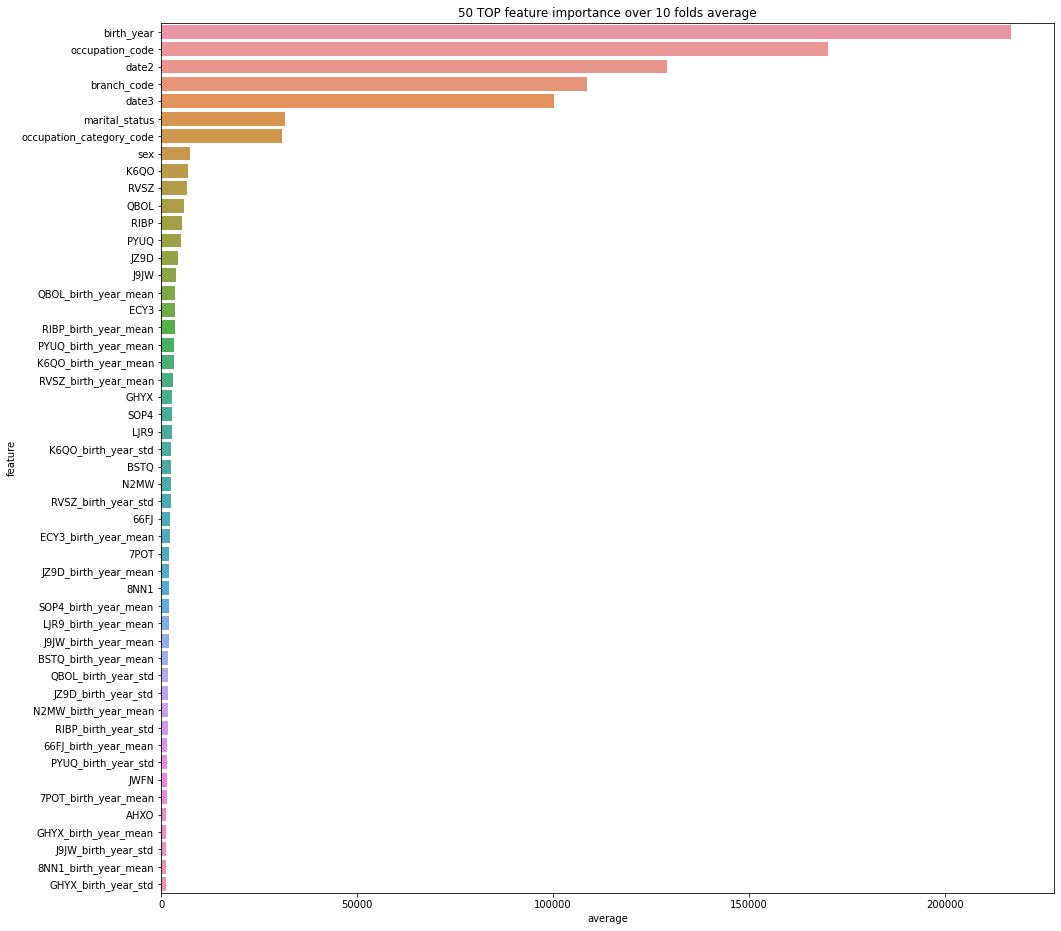

In [ ]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [ ]:
y_test = pd.DataFrame(preds)
y_test.columns = le.inverse_transform(y_test.columns)

In [ ]:
answer_mass = []
for i in range(X_test.shape[0]):
    id = test_ids.iloc[i]
    for c in y_test.columns:
        answer_mass.append([id + ' X ' + c, y_test[c].iloc[i]])

df_answer = pd.DataFrame(answer_mass)
df_answer.columns = ['ID X PCODE', 'Label']
for i in range(df_answer.shape[0]):
    if df_answer['ID X PCODE'].iloc[i] in true_values:
        df_answer['Label'].iloc[i] = 1.0

In [ ]:
df_answer.reset_index(drop=True, inplace=True)
df_answer.to_csv('submission_kfold_10.csv', index=False)